<a href="https://colab.research.google.com/github/Monsurat-Onabajo/DeepLearning_projects/blob/main/Foodvision_computervision_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch model deployment

## Get setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3830, done.
remote: Counting objects: 100% (473/473), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 3830 (delta 248), reused 400 (delta 202), pack-reused 3357
Receiving objects: 100% (3830/3830), 649.88 MiB | 29.03 MiB/s, done.
Resolving deltas: 100% (2204/2204), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Data

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
data_20_percent_path

PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
train_dir= data_20_percent_path/ 'train'
test_dir= data_20_percent_path/ 'test'

In [ ]:
## Creating transform for the data for efficientnetb2 model
effnet_weights= torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnet_model= torchvision.models.efficientnet_b2(weights=effnet_weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 84.1MB/s]


In [ ]:
effnet_transform= effnet_weights.transforms()
effnet_transform

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_dataloader_effnet, test_dataloader_effnet, class_names= data_setup.create_dataloaders(train_dir= train_dir,
                                                                                            test_dir= test_dir, transform= effnet_transform,
                                                                                            batch_size=32)

In [ ]:
train_dataloader_effnet, test_dataloader_effnet, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f0e94b38400>,
 ['pizza', 'steak', 'sushi'])

## Create an effnet feature extractor

In [ ]:
effnet_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Get a summary of the module
summary(model= effnet_model,
        input_size=(1,3,224,224),
        col_names= ['input_size', 'output_size','num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [ ]:
for param in effnet_model.parameters():
  param.requires_grad= False

In [ ]:
# Get a summary of the module
summary(model= effnet_model,
        input_size=(1,3,224,224),
        col_names= ['input_size', 'output_size','num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [ ]:
effnet_model.classifier= nn.Sequential(
    nn.Dropout(p=0.3, inplace= True),
    nn.Linear(in_features=1408, out_features=len(class_names)
    #, bias= True
              )
).to(device)

In [ ]:
# Get a summary of the module
summary(model= effnet_model,
        input_size=(1,3,224,224),
        col_names= ['input_size', 'output_size','num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
loss_fn= nn.CrossEntropyLoss()
optim= torch.optim.Adam(params= effnet_model.parameters(), lr=0.001)

In [ ]:
effnet_result= engine.train(model= effnet_model, train_dataloader= train_dataloader_effnet,
                            test_dataloader= test_dataloader_effnet, optimizer= optim,
                            loss_fn=loss_fn, epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9670 | train_acc: 0.5938 | test_loss: 0.7671 | test_acc: 0.7608
Epoch: 2 | train_loss: 0.7233 | train_acc: 0.7792 | test_loss: 0.6190 | test_acc: 0.9165
Epoch: 3 | train_loss: 0.5815 | train_acc: 0.8854 | test_loss: 0.5373 | test_acc: 0.9318
Epoch: 4 | train_loss: 0.4741 | train_acc: 0.9062 | test_loss: 0.4537 | test_acc: 0.9500
Epoch: 5 | train_loss: 0.4118 | train_acc: 0.9187 | test_loss: 0.3992 | test_acc: 0.9318
Epoch: 6 | train_loss: 0.4296 | train_acc: 0.8771 | test_loss: 0.3744 | test_acc: 0.9256
Epoch: 7 | train_loss: 0.4183 | train_acc: 0.8562 | test_loss: 0.3562 | test_acc: 0.9290
Epoch: 8 | train_loss: 0.3059 | train_acc: 0.9396 | test_loss: 0.3353 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.3251 | train_acc: 0.8979 | test_loss: 0.2997 | test_acc: 0.9659
Epoch: 10 | train_loss: 0.3417 | train_acc: 0.8708 | test_loss: 0.2972 | test_acc: 0.9443


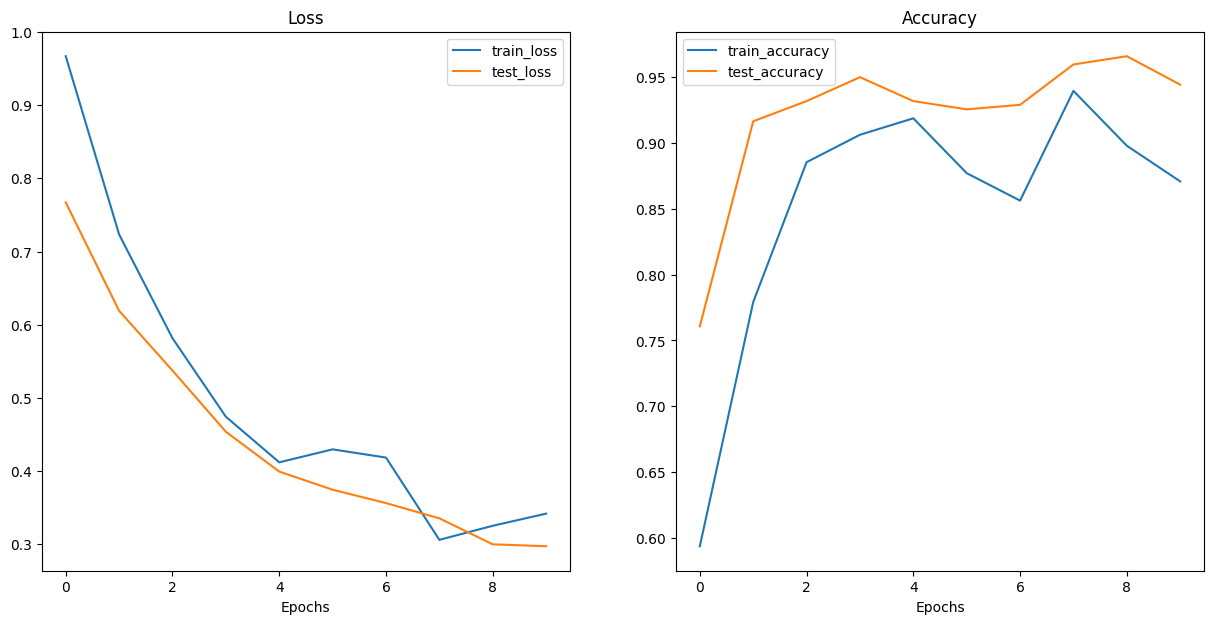

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnet_result)

## Saving our effnet model

In [ ]:
from going_modular.going_modular import utils

# save module
utils.save_model(model= effnet_model,target_dir= 'models',
                 model_name= 'effnet_b2_model.pth')

[INFO] Saving model to: models/effnet_b2_model.pth


In [ ]:
## Inspecting the size of our model
from pathlib import Path
# get the model size in bytes
model_size_bytes= Path('models/effnet_b2_model.pth').stat().st_size
model_size_mb= model_size_bytes/ (1024*1024)
print(f' efficient net b2 model size is: {round(model_size_mb, 2)}')

 efficient net b2 model size is: 29.83


##  Collecting EffB2 Feature extractor stat

In [ ]:
# count no of parameters in EfficientNetB2 model
effnetb2_total_params=sum(torch.numel(params) for params in effnet_model.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with effnetb2 statistics
effnetb2_stats= {'test_loss': effnet_result['test_loss'][-1],
                 'test_acc': effnet_result['test_acc'][-1],
                 'model_size_[mb]': model_size_mb,
                 'no_of_parameters': effnetb2_total_params
                 }

In [ ]:
effnetb2_stats

{'test_loss': 0.29715073108673096,
 'test_acc': 0.9443181818181818,
 'model_size_[mb]': 29.828728675842285,
 'no_of_parameters': 7705221}

## Doing the same for ViT extractor model

In [ ]:
# get model, transform and model weights
vit_weights= torchvision.models.ViT_B_16_Weights.DEFAULT
vit_transform= vit_weights.transforms()
vit_model= torchvision.models.vit_b_16(weights= vit_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 262MB/s]


In [ ]:
# Create dataloaders
train_dataloader_vit, test_dataloader_vit, class_names= data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir,transform=vit_transform,batch_size=32
)

In [ ]:
train_dataloader_vit, test_dataloader_vit, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f0e8e74e2c0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
vit_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Get a summary of the module
summary(model= vit_model,
        input_size=(1,3,224,224),
        col_names= ['input_size', 'output_size','num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [ ]:
vit_model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
# freeze all the model base
for param in vit_model.parameters():
  param.requires_grad= False

vit_model.heads= nn.Sequential(nn.Linear(in_features=768, out_features=len(class_names))).to(device)

In [ ]:
# Get a summary of the module
summary(model= vit_model,
        input_size=(1,3,224,224),
        col_names= ['input_size', 'output_size','num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
# create loss function and optimizer
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= vit_model.parameters(), lr=0.001)

In [ ]:
# train the model
vit_results= engine.train(
    train_dataloader= train_dataloader_vit, test_dataloader= test_dataloader_vit,
    epochs=10,loss_fn=loss_fn, optimizer= optimizer, device=device, model= vit_model
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6134 | train_acc: 0.8063 | test_loss: 0.2294 | test_acc: 0.9750
Epoch: 2 | train_loss: 0.2392 | train_acc: 0.9208 | test_loss: 0.1272 | test_acc: 0.9938
Epoch: 3 | train_loss: 0.1476 | train_acc: 0.9604 | test_loss: 0.1036 | test_acc: 0.9875
Epoch: 4 | train_loss: 0.1199 | train_acc: 0.9667 | test_loss: 0.0860 | test_acc: 0.9875
Epoch: 5 | train_loss: 0.1029 | train_acc: 0.9708 | test_loss: 0.0769 | test_acc: 0.9875
Epoch: 6 | train_loss: 0.0897 | train_acc: 0.9750 | test_loss: 0.0710 | test_acc: 0.9938
Epoch: 7 | train_loss: 0.0787 | train_acc: 0.9792 | test_loss: 0.0669 | test_acc: 0.9938
Epoch: 8 | train_loss: 0.0705 | train_acc: 0.9812 | test_loss: 0.0629 | test_acc: 0.9938
Epoch: 9 | train_loss: 0.0655 | train_acc: 0.9833 | test_loss: 0.0595 | test_acc: 0.9938
Epoch: 10 | train_loss: 0.0564 | train_acc: 0.9896 | test_loss: 0.0564 | test_acc: 0.9875


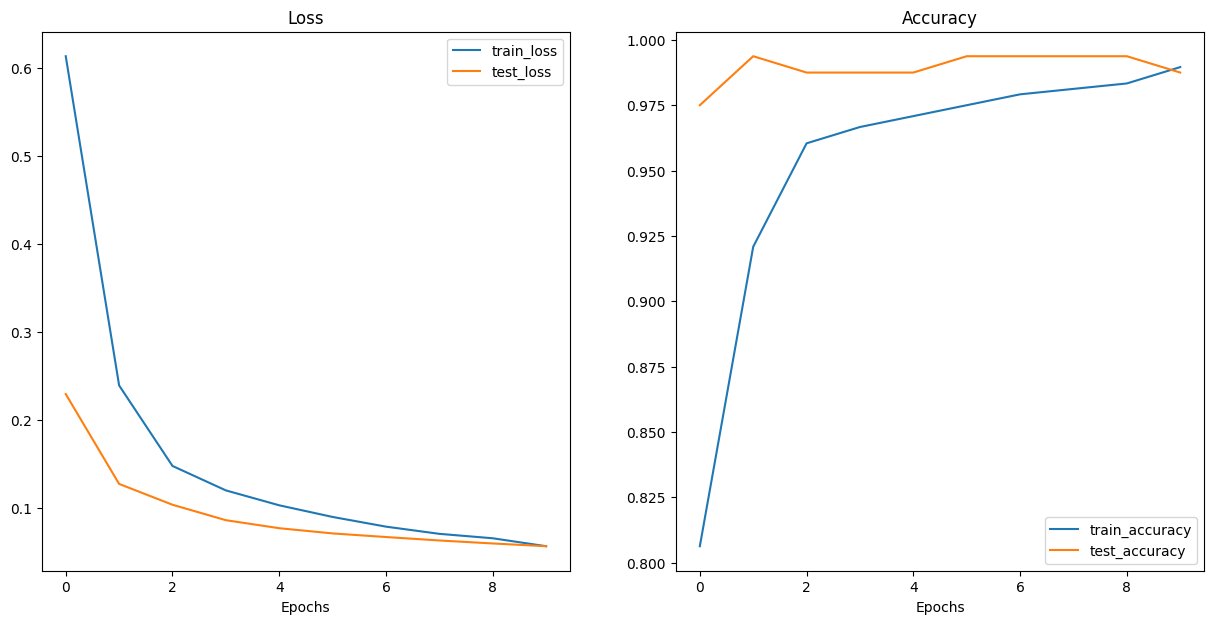

In [ ]:
# plot loss curves
plot_loss_curves(vit_results)

In [ ]:
# save the model
utils.save_model(model= vit_model,target_dir= 'models',
                 model_name= 'vit_b16_model.pth')

[INFO] Saving model to: models/vit_b16_model.pth


In [ ]:
# get vit model size in bytes and convert to mega bytes
vit_size= Path('models/vit_b16_model.pth').stat().st_size
vit_size_mb= vit_size/(1024*1024)
print(f' efficient net b2 model size is: {round(vit_size_mb, 2)}')

 efficient net b2 model size is: 327.36


In [ ]:
# count no of parameters in EfficientNetB2 model
vit_total_params=sum(torch.numel(params) for params in vit_model.parameters())
vit_total_params

85800963

In [ ]:
# create stats for the vit model
vit_stats= {'test_loss': vit_results['test_loss'][-1],
            'test_acc': vit_results['test_acc'][-1],
            'model_size_[mb]': vit_size_mb,
            'no_of_parameters': vit_total_params
            }
vit_stats

{'test_loss': 0.056429096544161436,
 'test_acc': 0.9875,
 'model_size_[mb]': 327.36271381378174,
 'no_of_parameters': 85800963}

## Making predictions with our models and timing them

In [ ]:
# get all test path
test_data_path=list(Path(test_dir).glob('*/*.jpg'))
test_data_path[: 10]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2365038.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/399377.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/831681.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1082384.jpg')]

In [ ]:
for i in test_data_path[: 10]:
  print (i)

data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg
data/pizza_steak_sushi_20_percent/test/steak/2365038.jpg
data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg
data/pizza_steak_sushi_20_percent/test/steak/399377.jpg
data/pizza_steak_sushi_20_percent/test/steak/1285886.jpg
data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg
data/pizza_steak_sushi_20_percent/test/steak/39461.jpg
data/pizza_steak_sushi_20_percent/test/steak/413497.jpg
data/pizza_steak_sushi_20_percent/test/steak/831681.jpg
data/pizza_steak_sushi_20_percent/test/steak/1082384.jpg


In [ ]:
test_data_path[1].parent.stem

'steak'

In [ ]:
from timeit import default_timer as timer
from PIL import Image
from tqdm.auto import tqdm

# make a function that will loop through an image path and make predictions.
def pred_and_store(path_list: list, model: torchvision.models,
                   transforms, target_names, device):
  pred_list= []
  for i in tqdm(path_list):
    pred_stat= {}
    # get the sample path and ground truth from the file path
    pred_stat['image_path'] = i
    truth_class= i.parent.stem
    pred_stat['class_name']= truth_class
    # Turn on timer
    start_timer= timer()
    # open the image with Pil and transform pil image
    image= Image.open(i)
    transform_img= transforms(image).unsqueeze(0).to(device)

    # send model to target device
    model= model.to(device)
    # turn on eval mode
    model.eval()
    # turn on torch inference mode
    with torch.inference_mode():
      pred_logit= model(transform_img)
      pred_prob= torch.softmax(pred_logit, dim=1)
      pred_label= torch.argmax(pred_prob, dim=1).to('cpu')
      pred_stat['prediction_probability'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_stat['prediction class']= target_names[pred_label]
    end_timer= timer()
    pred_stat['timer']= round(end_timer-start_timer, 4)

    # see if the pred class matches the ground truth class
    pred_stat['correct'] = truth_class == target_names[pred_label]
    # append the updated dic to the list
    pred_list.append(pred_stat)

  return pred_list



In [ ]:
effnet_pred_list= pred_and_store(path_list= test_data_path,
                                 device='cpu',
                                 model= effnet_model,
                                 transforms=effnet_transform,
                                 target_names= class_names )

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnet_pred_list[:4]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
  'class_name': 'steak',
  'prediction_probability': 0.8533,
  'prediction class': 'steak',
  'timer': 0.2777,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2365038.jpg'),
  'class_name': 'steak',
  'prediction_probability': 0.7401,
  'prediction class': 'steak',
  'timer': 0.1097,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
  'class_name': 'steak',
  'prediction_probability': 0.7982,
  'prediction class': 'steak',
  'timer': 0.1057,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/399377.jpg'),
  'class_name': 'steak',
  'prediction_probability': 0.7448,
  'prediction class': 'steak',
  'timer': 0.1059,
  'correct': True}]

# Turn it into a dataframe

In [ ]:
import pandas as pd
effnet_df= pd.DataFrame(effnet_pred_list)
effnet_df.head()

,image_path,class_name,prediction_probability,prediction class,timer,correct
0,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8533,steak,0.2777,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.7401,steak,0.1097,True
2,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7982,steak,0.1057,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.7448,steak,0.1059,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8817,steak,0.1046,True


In [ ]:
effnet_df['correct'].value_counts()

True     142
False      8
Name: correct, dtype: int64

In [ ]:
avg_time_effnet= round(sum(effnet_df['timer'])/len(effnet_df), 4)
avg_time_effnet

0.1121

## Doing the same to Vit model

In [ ]:
vit_pred_list= pred_and_store(path_list= test_data_path,
                                 device='cpu',
                                 model= vit_model,
                                 transforms=vit_transform,
                                 target_names= class_names )

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_df= pd.DataFrame(vit_pred_list)
vit_df.head()

,image_path,class_name,prediction_probability,prediction class,timer,correct
0,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9958,steak,0.7676,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9587,steak,0.5821,True
2,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9931,steak,0.9301,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9089,steak,0.9195,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9631,steak,0.8299,True


In [ ]:
vit_df['correct'].value_counts()

True     148
False      2
Name: correct, dtype: int64

In [ ]:
avg_time_vit= round(sum(vit_df['timer'])/len(effnet_df), 4)
avg_time_vit

0.6106

## Add avg time per prediction to vit and effnet stats

In [ ]:
vit_stats['average_time_per_pred_cpu']= avg_time_vit
effnetb2_stats['average_time_per_pred_cpu']= avg_time_effnet

In [ ]:
vit_stats

{'test_loss': 0.056429096544161436,
 'test_acc': 0.9875,
 'model_size_[mb]': 327.36271381378174,
 'no_of_parameters': 85800963,
 'average_time_per_pred_cpu': 0.6106}

In [ ]:
effnetb2_stats

{'test_loss': 0.29715073108673096,
 'test_acc': 0.9443181818181818,
 'model_size_[mb]': 29.828728675842285,
 'no_of_parameters': 7705221,
 'average_time_per_pred_cpu': 0.1121}

## Comparing model results, Prediction times and size

In [ ]:
# turn both stat dictionary to dataframe
stat_df= pd.DataFrame([effnetb2_stats,vit_stats])
# add col for model name
stat_df['model']= ['EffNetB2', 'Vit']

# convert accuracy to percentages
stat_df['test_acc']= round(stat_df['test_acc']*100, 2)
stat_df

,test_loss,test_acc,model_size_[mb],no_of_parameters,average_time_per_pred_cpu,model
0,0.297151,94.43,29.828729,7705221,0.1121,EffNetB2
1,0.056429,98.75,327.362714,85800963,0.6106,Vit


## Compare Vit to EffnetB2 across different characteristics

In [ ]:
pd.DataFrame(stat_df.set_index('model').loc['Vit']/ stat_df.set_index('model').loc['EffNetB2'],
             columns= ['Vit to effnetb2 ratios']).T

,test_loss,test_acc,model_size_[mb],no_of_parameters,average_time_per_pred_cpu
Vit to effnetb2 ratios,0.189901,1.045748,10.974746,11.135432,5.446922


## Visualizing the speed vs performance ratio

In [ ]:
for a,b in stat_df.iterrows():
  print (b)

test_loss                     0.297151
test_acc                         94.43
model_size_[mb]              29.828729
no_of_parameters               7705221
average_time_per_pred_cpu       0.1121
model                         EffNetB2
Name: 0, dtype: object
test_loss                      0.056429
test_acc                          98.75
model_size_[mb]              327.362714
no_of_parameters               85800963
average_time_per_pred_cpu        0.6106
model                               Vit
Name: 1, dtype: object


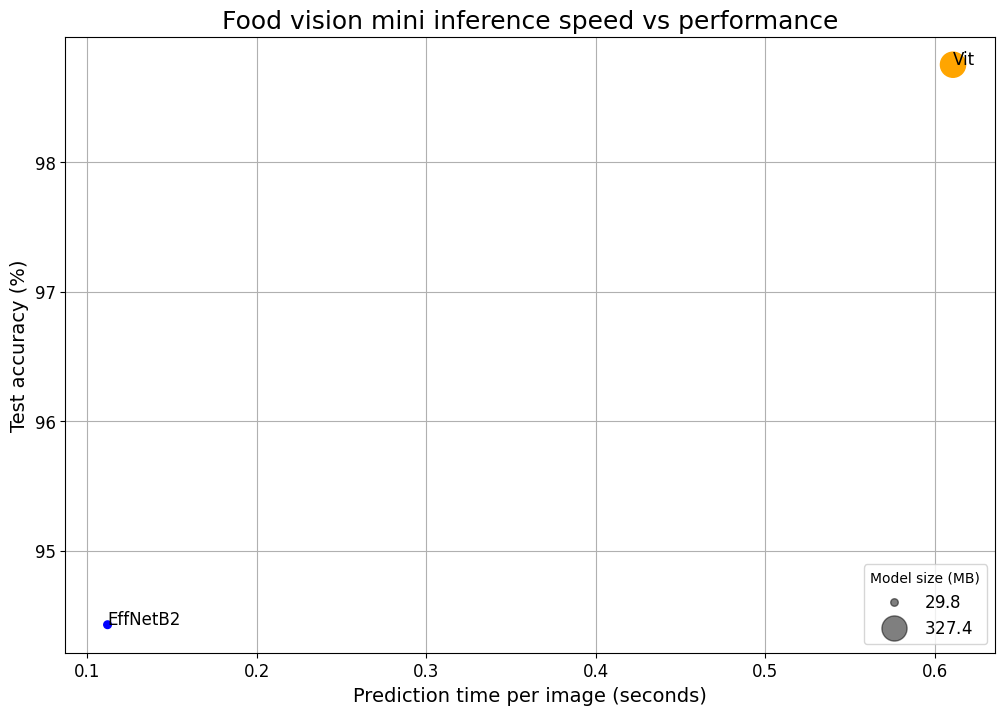

In [ ]:
import matplotlib.pyplot as plt

fig, ax= plt.subplots(figsize=(12,8))
scatter= ax.scatter(data=stat_df,
                    x='average_time_per_pred_cpu',
                    y= 'test_acc',
                    c=['blue', 'orange'],
                    s='model_size_[mb]')
# add titles and labels
ax.set_title('Food vision mini inference speed vs performance', fontsize=18)
ax.set_xlabel('Prediction time per image (seconds)', fontsize=14)
ax.set_ylabel('Test accuracy (%)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# Annotate the samples on the scatterplot so we know what is going on
for index, row in stat_df.iterrows():
  ax.annotate(text= row['model'],
              xy=(row['average_time_per_pred_cpu'], row['test_acc']),
              size=12)

# Create a legend based on the model sizes
handles, labels= scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend= ax.legend(handles, labels, loc= 'lower right',
                             title='Model size (MB)',
                             fontsize=12)
# save the figure
plt.savefig('foodvision-mini-plot.png')

# Bringing Food vision mini to life using Gradio demo

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.8 MB/s eta 0:

## Create a function to map our input and output

In [ ]:
# Put our model to the cpu
model= effnet_model.to('cpu')

# check the device
next(iter(model.parameters())).device

device(type='cpu')

In [ ]:
effnet_transform

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
from typing import Tuple, Dict

def predict(img)-> Tuple[Dict, float]:
  # start a timer
  start_time= timer()

  #transform the input image for use with effnet b2
  transform_image= effnet_transform(img).unsqueeze(0)

  #put model into eval mode, make pred
  model.eval()
  with torch.inference_mode():
    pred_logits= model(transform_image)
    pred_prob= torch.softmax(pred_logits, dim=1)

  # create a pred label and pred prob dict
  pred_label_and_prob= {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}


  # calc pred time
  stop_time= timer()
  pred_time= round(stop_time - start_time, 4)


  # return pred dict and pred time
  return pred_label_and_prob, pred_time




In [ ]:
# Test the code by getting a random image from our data
import random
test_data_path= list(Path(test_dir).glob('*/*.jpg'))
test_data_path[0]

# randomly select a test image path
random_image_path = random.sample(test_data_path, k=1)[0]
random_image_path

# open our image
image= Image.open(random_image_path)
print(f' [INFO] Predicting on image at path: {random_image_path}\n')

# pass the image through our predict function
pred_dict, pred_time= predict(img=image)

print(pred_dict)
print(pred_time)

 [INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg

{'pizza': 0.48626115918159485, 'steak': 0.1742788851261139, 'sushi': 0.3394598960876465}
0.1052


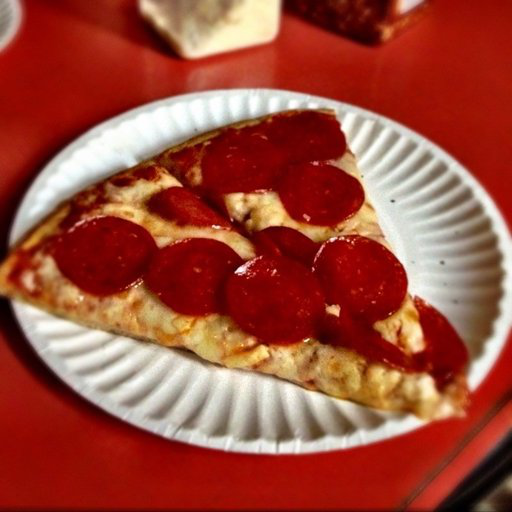

In [ ]:
image

## Creating a list of example images to use for our gradio demo

In [ ]:
example_list= [[str(filepath)] for filepath in random.sample(test_data_path, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/420409.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg']]

## Build a Gradio interface

In [ ]:
import gradio as gr

title= 'FoodVision Mini 🍕🥩🍣 '
description= 'An EfficientnetB2 feature extractor Computer vision model to classify image as pizza, steak or sushi'
article= 'Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).'

# Create the gradio demo
demo= gr.Interface(fn= predict,
                   inputs=gr.Image(type='pil'),
                   outputs= [gr.Label(num_top_classes=3, label= 'predictions'),
                             gr.Number(label= 'Prediction time (S)')],
                   examples= example_list,
                   title= title,
                   description= description,
                   article= article
                   )

# Launch the demo
#demo.launch()
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f97a18de18e720eda7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Turning our foodvision mini gradio demo into a deployable app

* Deploy Gradio App Structure
* Create a demo folder to store our foodvision app files

In [ ]:
import shutil
from pathlib import Path

# Create Foodvision mini demo path
food_vision_mini_demo_path= Path('demos/foodvision_mini/')

# remove files that already exist and create new dir
if food_vision_mini_demo_path.exists():
  shutil.rmtree(food_vision_mini_demo_path)
  food_vision_mini_demo_path.mkdir(parents= True,
                                   exist_ok= True)
else:
  food_vision_mini_demo_path.mkdir(parents= True,
                                   exist_ok= True)

In [ ]:
!ls demos/foodvision_mini/

## Create a folder of example images to use in our demo

In [ ]:
# create an example dir
food_vision_mini_example_path= food_vision_mini_demo_path/ 'example'
food_vision_mini_example_path.mkdir(parents=True, exist_ok= True)

# Collect three random test dataset
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# copy the three images to the example directory
for example in foodvision_mini_examples:
  destination= food_vision_mini_example_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/example/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/example/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/example/2582289.jpg


## lets verify that we can get a list of lists from our examples directorty

In [ ]:
import os

# Get example file path in a list of list
example_list= [['example/'+example] for example in os.listdir(food_vision_mini_example_path)]
example_list

[['example/592799.jpg'], ['example/3622237.jpg'], ['example/2582289.jpg']]

## Moving our foodvision model to demo dir

In [ ]:
# Create a source path for our target model
effnetb2_foodvision_model_path='models/effnet_b2_model.pth'

# Create a destination path
effnetb2_foodvision_model_path_dest= food_vision_mini_demo_path/ effnetb2_foodvision_model_path.split('/')[1]
effnetb2_foodvision_model_path_dest

# Try to move the model
try:
  print(f'[INFO] attempting to move {effnetb2_foodvision_model_path} to {effnetb2_foodvision_model_path_dest}')
  # move the model
  shutil.move(src= effnetb2_foodvision_model_path,
              dst= effnetb2_foodvision_model_path_dest)
  print (f'Model moved successful')

except:
  print(f'[INFO] no model found at {effnetb2_foodvision_model_path}, perhaps it has been moved')
  print(f'[INFO] Model exist at {effnetb2_foodvision_model_path_dest}: {effnetb2_foodvision_model_path_dest.exists()}')

[INFO] attempting to move models/effnet_b2_model.pth to demos/foodvision_mini/effnet_b2_model.pth
Model moved successful


## Turning off Effnet model into a python script

In [ ]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  # Create Effnet pretrained model
  weights= torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms= weights.transforms()
  model= torchvision.models.efficientnet_b2(weights=weights)

  # Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad= False

  # Change the classifier layer
  torch.manual_seed(seed)
  model.classifier= nn.Sequential(
      nn.Dropout(p=0.3, inplace= True),
      nn.Linear(in_features=1408, out_features= num_classes)
  )

  return model, transforms

Writing demos/foodvision_mini/model.py


In [ ]:
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transform= model.create_effnetb2_model()

## Turning our foodvision mini app into a python script

it will have four major parts
1. Import and class names setup
2. Model and transforms preparation
3. Predict function
4. Gradio app

In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
%%writefile demos/foodvision_mini/app.py

# Import and class names setup
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typings import Tuple, Dict

# Setup class names
class_names= ['pizza', 'steak', 'sushi']

# Model and transforms preparation
effnetb2_model, effnetb2_transform= create_effnetb2_model()
# Load state dict
effnetb2_model.load_state_dict(torch.load(
    f= 'effnet_b2_model.pth',
    map_location= torch.device('cpu')
    )
)

# Predict function

def predict(img)-> Tuple[Dict, float]:
  # start a timer
  start_time= timer()

  #transform the input image for use with effnet b2
  transform_image= effnetb2_transform(img).unsqueeze(0)

  #put model into eval mode, make pred
  effnetb2_model.eval()
  with torch.inference_mode():
    pred_logits= effnetb2_model(transform_image)
    pred_prob= torch.softmax(pred_logits, dim=1)

  # create a pred label and pred prob dict
  pred_label_and_prob= {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}


  # calc pred time
  stop_time= timer()
  pred_time= round(stop_time - start_time, 4)


  # return pred dict and pred time
  return pred_label_and_prob, pred_time

# create example list
example_list= [['example/'+example] for example in os.listdir('example')]

# create gradio app
title= 'FoodVision Mini 🍕🥩🍣 '
description= 'An EfficientnetB2 feature extractor Computer vision model to classify image as pizza, steak or sushi'
article= 'Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).'

# Create the gradio demo
demo= gr.Interface(fn= predict,
                   inputs=gr.Image(type='pil'),
                   outputs= [gr.Label(num_top_classes=3, label= 'predictions'),
                             gr.Number(label= 'Prediction time (S)')],
                   examples= example_list,
                   title= title,
                   description= description,
                   article= article
                   )

# Launch the demo
#demo.launch()
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?


Writing demos/foodvision_mini/app.py


## Create Requirements.txt

It will tell hugging face what requiremnets our model requires

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==3.35.2

Writing demos/foodvision_mini/requirements.txt


## Deploying our foodvision mini to huggingface space

* Downloading our foodvision mini demo app file

In [ ]:
!ls demos/foodvision_mini

app.py	effnet_b2_model.pth  example  model.py	__pycache__  requirements.txt


In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
'''
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")'''

  adding: app.py (deflated 54%)
  adding: effnet_b2_model.pth (deflated 8%)
  adding: example/ (stored 0%)
  adding: example/592799.jpg (deflated 1%)
  adding: example/3622237.jpg (deflated 0%)
  adding: example/2582289.jpg (deflated 17%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 8%)


'\ntry:\n    from google.colab import files\n    files.download("demos/foodvision_mini.zip")\nexcept:\n    print("Not running in Google Colab, can\'t use google.colab.files.download(), please manually download.")'

## See testing on a local machine in the textbook

## Uploading to huggingface spaces

* We did this locally

## we can also share our app by embedding it

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/OnabajoMonsurat/FoodVision_Mini_Class_Project/+", width=900, height=750)

## Creating Foodvision Big for 101 data classes

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  # Create Effnet pretrained model
  weights= torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms= weights.transforms()
  model= torchvision.models.efficientnet_b2(weights=weights)

  # Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad= False

  # Change the classifier layer
  torch.manual_seed(seed)
  model.classifier= nn.Sequential(
      nn.Dropout(p=0.3, inplace= True),
      nn.Linear(in_features=1408, out_features= num_classes)
  )

  return model, transforms

In [ ]:
# Create a model for foodvision big

effnetb2_food101, effnetb2_transform= create_effnetb2_model(num_classes =101)

# Get a summary of the module
summary(model= effnetb2_food101,
        input_size=(1,3,224,224),
        col_names= ['input_size', 'output_size','num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Add data augmentation to the transforms so our data dont overfit

In [ ]:
food101_transform= torchvision.transforms.Compose([torchvision.transforms.TrivialAugmentWide(),
                                                   effnetb2_transform])
food101_transform

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
# testing data transform
effnetb2_transform

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Getting data for foodvision big

In [ ]:
from torchvision import datasets

# Setup data dir
data_dir= Path('data')

# Get the training data (750*101)
train_data= datasets.Food101(root=data_dir,
                             split='train',
                             transform=food101_transform,
                             download= True)

test_data= datasets.Food101(root= data_dir,
                            split='test',
                            transform= effnetb2_transform,
                            download= True)

100%|██████████| 4996278331/4996278331 [04:13<00:00, 19671251.33it/s]


Extracting data/food-101.tar.gz to data


In [ ]:
dir(train_data)

['_MD5',
 '_URL',
 '__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_base_folder',
 '_check_exists',
 '_download',
 '_format_transform_repr',
 '_image_files',
 '_images_folder',
 '_is_protocol',
 '_labels',
 '_meta_folder',
 '_repr_indent',
 '_split',
 'class_to_idx',
 'classes',
 'extra_repr',
 'root',
 'target_transform',
 'transform',
 'transforms']

In [ ]:
train_data.classes[: 10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
len(train_data)

75750

## Create a 20% subset of the food101 dataset for faster experimenting

In [ ]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size: float= 0.2,
                  seed:int= 42):
  # Create split length based on original dataset length
  length_1= int(len(dataset) * split_size)
  length_2= len(dataset)-length_1

  # print out info
  print (f'[INFO] Splitting dataset of length {len(dataset)} into split size of {length_1} and {length_2}')

  # Create splits with given random seed
  random_split_1, random_split_2= random_split(dataset= dataset,
                                               lengths= [length_1, length_2],
                                               generator= torch.manual_seed(seed))

  return random_split_1, random_split_2

In [ ]:
# Create training 20% split food101
train_data_20, _= split_dataset(dataset= train_data, split_size=0.2)

# Create testing 20% spli
test_data_20, _= split_dataset(dataset= test_data, split_size=0.2)

[INFO] Splitting dataset of length 75750 into split size of 15150 and 60600
[INFO] Splitting dataset of length 25250 into split size of 5050 and 20200


In [ ]:
len(train_data_20), len(test_data_20)

(15150, 5050)

## Turn data to dataloaders

In [ ]:
os.cpu_count()

2

In [ ]:
from torch.utils.data import DataLoader
train_dataloader= DataLoader(dataset = train_data_20,
                             batch_size=32,
                             shuffle= True,
                             num_workers=2)

test_dataloader= DataLoader(dataset = test_data_20,
                             batch_size=32,
                             shuffle= False,
                             num_workers=2)

class_names= train_data.classes

In [ ]:
len(train_dataloader)

474

## Training foodvision big

In [ ]:
from going_modular.going_modular import engine

# Set up optimizer and loss fn
optimizer= torch.optim.Adam(params= effnetb2_food101.parameters(), lr=0.001)
loss_fn= torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# goal is to beat the original food101 test result of 56.4% on the dataset with 20% of the data
set_seeds()
effnetb2_food101_result= engine.train(model= effnetb2_food101,
                                      train_dataloader= train_dataloader,
                                      test_dataloader= test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn= loss_fn, epochs=5,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5555 | train_acc: 0.5384 | test_loss: 2.4838 | test_acc: 0.5295
Epoch: 2 | train_loss: 2.6874 | train_acc: 0.4730 | test_loss: 2.3693 | test_acc: 0.5541
Epoch: 3 | train_loss: 2.5710 | train_acc: 0.5043 | test_loss: 2.3138 | test_acc: 0.5689
Epoch: 4 | train_loss: 2.4924 | train_acc: 0.5228 | test_loss: 2.2746 | test_acc: 0.5777
Epoch: 5 | train_loss: 2.4628 | train_acc: 0.5322 | test_loss: 2.2662 | test_acc: 0.5824


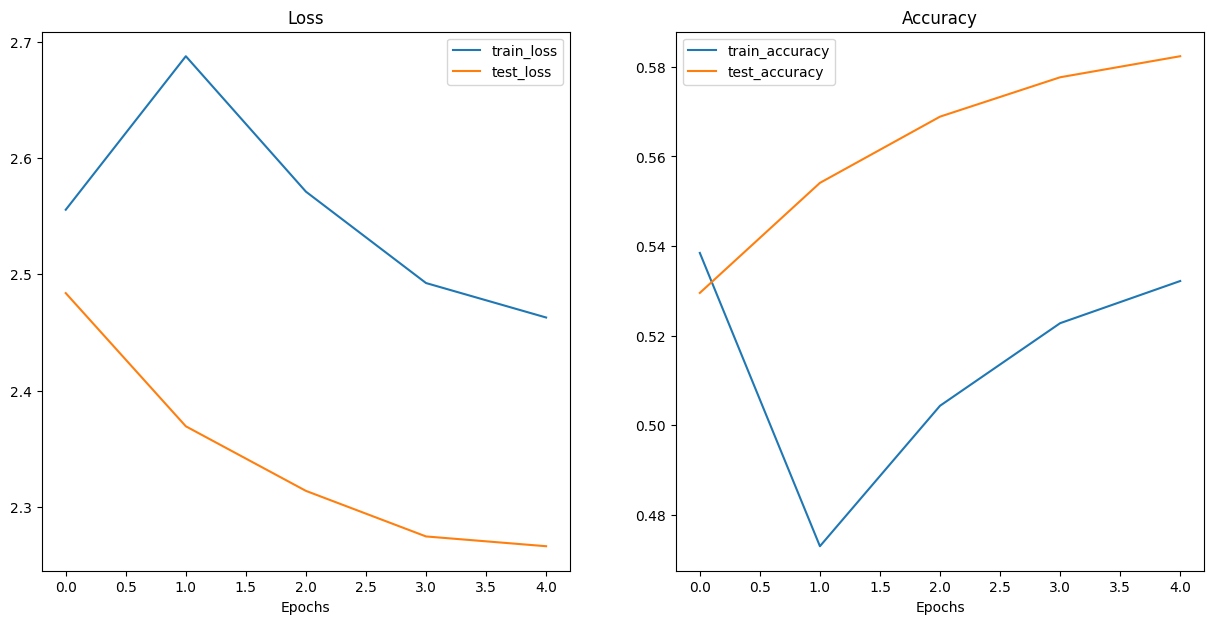

In [ ]:
## Inspect the loss curve of our model
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_food101_result)

## Save and load foodvision big model

In [ ]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path= 'effnetb2_food101_model.pth'

# Save the model
utils.save_model(model=effnetb2_food101,
                 target_dir= 'models/',
                 model_name= effnetb2_food101_model_path)

[INFO] Saving model to: models/effnetb2_food101_model.pth


In [ ]:
# Create food101 compatible effnet instance
loaded_effnetb2, transforms= create_effnetb2_model(num_classes=101)

# load the saved model state dict
loaded_effnetb2.load_state_dict(torch.load('models/effnetb2_food101_model.pth'))

<All keys matched successfully>

## Turning our food101 model intp a deployable model

In [ ]:
# Create foodvision big demo path
path= Path('demos/foodvision_big')

# Make foodvision big with
path.mkdir(parents= True, exist_ok= True)

# Make foodvision big demo example directory
path_example= path/'example'
path_example.mkdir(parents= True, exist_ok= True)


## Putting example into our example dir

In [ ]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/example/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/effnetb2_food101_model.pth demos/foodvision_big

--2023-06-24 16:04:50--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.06s   

2023-06-24 16:04:50 (49.5 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



## Create classnames to txt file

In [ ]:
## Create classnames to txt file
txt_path= path/'class_names.txt'
with open(txt_path, 'w') as f:
  f.write('\n'.join(class_names))

In [ ]:
## open food101 text file and read them into a list
with open(txt_path, 'r') as f:
  loaded= [food.strip() for food in f.readlines()]


In [ ]:
%%writefile demos/foodvision_big/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=101,
                          seed:int=42):
  # Create Effnet pretrained model
  weights= torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms= weights.transforms()
  model= torchvision.models.efficientnet_b2(weights=weights)

  # Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad= False

  # Change the classifier layer
  torch.manual_seed(seed)
  model.classifier= nn.Sequential(
      nn.Dropout(p=0.3, inplace= True),
      nn.Linear(in_features=1408, out_features= num_classes)
  )

  return model, transforms


Writing demos/foodvision_big/model.py


## Turning our foodvision gradio app.py script

In [ ]:
%%writefile demos/foodvision_big/app.py

# Import and class names setup
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typings import Tuple, Dict
import class_names

# Setup class names
with open(class_names.txt, 'r') as f:
  class_names= [food_name.strip() for food_name in f.readlines()]


# Model and transforms preparation
effnetb2_model, effnetb2_transform= create_effnetb2_model()
# Load state dict
effnetb2_model.load_state_dict(torch.load(
    f= 'effnetb2_food101_model.pth',
    map_location= torch.device('cpu')
    )
)

# Predict function

def predict(img)-> Tuple[Dict, float]:
  # start a timer
  start_time= timer()

  #transform the input image for use with effnet b2
  transform_image= effnetb2_transform(img).unsqueeze(0)

  #put model into eval mode, make pred
  effnetb2_model.eval()
  with torch.inference_mode():
    pred_logits= effnetb2_model(transform_image)
    pred_prob= torch.softmax(pred_logits, dim=1)

  # create a pred label and pred prob dict
  pred_label_and_prob= {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}


  # calc pred time
  stop_time= timer()
  pred_time= round(stop_time - start_time, 4)


  # return pred dict and pred time
  return pred_label_and_prob, pred_time

# create example list
example_list= [['example/'+example] for example in os.listdir('example')]

# create gradio app
title= 'FoodVision Large 🍕🥩🍣 '
description= 'An EfficientnetB2 feature extractor Computer vision model to classify 101 classes of food from the food 101 image dataset'
article= 'Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).'

# Create the gradio demo
demo= gr.Interface(fn= predict,
                   inputs=gr.Image(type='pil'),
                   outputs= [gr.Label(num_top_classes=5, label= 'predictions'),
                             gr.Number(label= 'Prediction time (S)')],
                   examples= example_list,
                   title= title,
                   description= description,
                   article= article
                   )

# Launch the demo
demo.launch()


Writing demos/foodvision_big/app.py


In [ ]:
%%writefile demos/foodvision_big/requirements.txt

torch==2.0.1
torchvision==0.15.2
gradio==3.35.2

Writing demos/foodvision_big/requirements.txt


## Zip the file and download it

In [ ]:
# Change into and then zip the foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision big app (if running in Google Colab)

try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: effnetb2_food101_model.pth (deflated 8%)
  adding: example/ (stored 0%)
  adding: example/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>